<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/Widen00-Lab3/Lab3/Widen00_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Approximations**
**Joel Widén**

# **Abstract**



```
# This is formatted as code
```

Short summary of the lab report. State the objectives, methods used, main results and conlusions.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license.

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *

#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

1. Function: L2 projection to pw linear approximation over mesh in 1D

Input: function f(x), 1D mesh with nodes (x0,...,xn)
Output: vector of L2 projection of f(x) evaluated in (x0,...,xn)
Test: verify accuracy and convergence rate against exact function

# **Method**

[-4.00000000e+00 -3.95000000e+00 -3.90000000e+00 -3.85000000e+00
 -3.80000000e+00 -3.75000000e+00 -3.70000000e+00 -3.65000000e+00
 -3.60000000e+00 -3.55000000e+00 -3.50000000e+00 -3.45000000e+00
 -3.40000000e+00 -3.35000000e+00 -3.30000000e+00 -3.25000000e+00
 -3.20000000e+00 -3.15000000e+00 -3.10000000e+00 -3.05000000e+00
 -3.00000000e+00 -2.95000000e+00 -2.90000000e+00 -2.85000000e+00
 -2.80000000e+00 -2.75000000e+00 -2.70000000e+00 -2.65000000e+00
 -2.60000000e+00 -2.55000000e+00 -2.50000000e+00 -2.45000000e+00
 -2.40000000e+00 -2.35000000e+00 -2.30000000e+00 -2.25000000e+00
 -2.20000000e+00 -2.15000000e+00 -2.10000000e+00 -2.05000000e+00
 -2.00000000e+00 -1.95000000e+00 -1.90000000e+00 -1.85000000e+00
 -1.80000000e+00 -1.75000000e+00 -1.70000000e+00 -1.65000000e+00
 -1.60000000e+00 -1.55000000e+00 -1.50000000e+00 -1.45000000e+00
 -1.40000000e+00 -1.35000000e+00 -1.30000000e+00 -1.25000000e+00
 -1.20000000e+00 -1.15000000e+00 -1.10000000e+00 -1.05000000e+00
 -1.00000000e+00 -9.50000

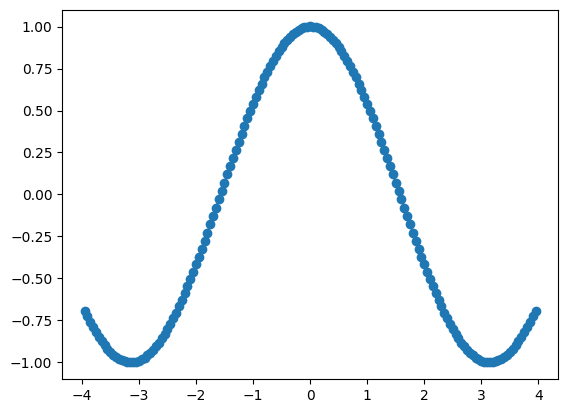

In [82]:
#L2 projection on pw to linear approximation over mesh in 1D


class loc2globmap:
  def __init__(self, A_map, b_map, dof):
    self.A_map = A_map
    self.b_map = b_map
    self.dof = dof

#Reference function
def f(x):
  fx =np.cos(x)
  return fx

#Input x, interval nr k, mesh and if it is the 0 or 1 polynomial in nr
def lin_lagrange_pol(x, mesh, k, nr):
  x_k = mesh[k+1]
  x_k_m1 = mesh[k]
  h_k = x_k - x_k_m1
  if nr == 0:
    lambdax =  (x_k - x)/h_k
  else:
    lambdax = (x- x_k_m1)/h_k
  return lambdax

def get_no_local_shape_functions(k):
  #since we have a linear basis V, q is 2 for all elements
  q = 2
  return q

#Define the local to global maps
def get_local_to_global_map(k):
  A_map = np.array([[k, k+1],[k,k+1]])
  b_map = np.array([k, k+1])
  dof = np.array([k, k+1])
  loc2glob = loc2globmap(A_map, b_map, dof)
  return loc2glob

#Integrating the vector using trapezoidal rule
def integrate_vector(f, k, i, mesh):
  a = mesh[k]
  b = mesh[k+1]
  # Trapezoidal rule
  bi = f(a)*lin_lagrange_pol(a, mesh, k, i)*0.5*(b-a) + f(b)*lin_lagrange_pol(b, mesh, k, i)*0.5*(b-a)
  return bi

#Integrating the matrix. This is only valid for continious piecewise linear
#lagrange polynomials
def integrate_matrix(k, i, j,mesh):
  hk = mesh[k+1]-mesh[k]
  if i == j:
    aij = hk/3
  else:
    aij = hk/6
  return aij

#Add local vector to global vector
def add_to_global_vector(b, b_k, loc2glob):
  b[loc2glob.b_map[0]:loc2glob.b_map[1]+1] = b[loc2glob.b_map[0]:loc2glob.b_map[1]+1] + b_k
  return b

#Add local matrix to global matrix
def add_to_global_matrix(A, a_k, loc2glob):
  A[loc2glob.A_map[0][0]:loc2glob.A_map[0][1]+1, loc2glob.A_map[1][0]:loc2glob.A_map[1][1]+1] = A[loc2glob.A_map[0][0]:loc2glob.A_map[0][1]+1, loc2glob.A_map[1][0]:loc2glob.A_map[1][1]+1] + a_k
  return A

#From algorithm 9.2 to assemble the local matrixes into the global matrix
def assembly_system(f, A, b, mesh):
  no_elements = len(b)-1
  for k in range(0, no_elements):
    q = get_no_local_shape_functions(k)
    loc2glob = get_local_to_global_map(k)
    b_k = np.zeros(q)
    a_k = np.zeros((q, q))
    for i in range(0, q):
      b_k[i] = integrate_vector(f, k, i, mesh)
      for j in range(0, q):
        a_k[i, j] = integrate_matrix(k, i, j, mesh)
    b = add_to_global_vector(b, b_k, loc2glob)
    A = add_to_global_matrix(A, a_k, loc2glob)
  return A, b


#Get coordinates alpha by solving matrix equation
def coordinates(A, b):
  A_inv = np.linalg.inv(A)
  alpha = A_inv.dot(b)
  return alpha

#Find what subinterval x is in
def find_subinterval(x, mesh):
  for i in range(0, len(mesh)-1):
    if mesh[i]<= x <=mesh[i+1]:
      k = i
  return k

#Extract local dofs from alpha using the map from local to global
def get_local_dofs(alpha, loc2glob):
  beta = [alpha[loc2glob.dof[0]], alpha[loc2glob.dof[1]]]
  return beta

#This function is inspired by algorithm 9.1 but modified to calculate
#phi
def eval_pwp_function(alpha, x, q, mesh):
  k = find_subinterval(x, mesh)
  loc2glob = get_local_to_global_map(k)
  beta = get_local_dofs(alpha, loc2glob)
  f = 0
  for j in range(0,len(beta)):
    lambdax= lin_lagrange_pol(x, mesh, k, j)
    f += beta[j]*lambdax
  return f

"""Performing linear projection calculations.
This can be seen as the master function doing assembly and projection."""
def l2_to_pw(f, mesh):

  A = np.zeros((len(mesh), len(mesh)))
  b = np.zeros(len(mesh))

  #Assemble
  A, b = assembly_system(f, A, b, mesh)

  #Get alpha coordinates
  alpha = coordinates(A, b)



  #Calculate for inner range to avoid rounding errors in mesh edge, this is just
  #for fun
  x_0 = mesh[1]
  x_m1 = mesh[-2]
  #This is put as interval for mesh to get the points xn
  interval = 0.05
  nr_points = round((x_m1 - x_0)/interval)
  x_vec = np.zeros(nr_points+1)
  x = x_0
  for i in range(0, nr_points+1):
    x_vec[i] = x
    x += interval
  print(mesh)
  print(x_vec)
  l2_to_pw = np.zeros_like(x_vec)
  for i in range(0, len(x_vec)):
    x = x_vec[i]
    q = 1
    l2_to_pw[i] = eval_pwp_function(alpha, x, q, mesh)

  return l2_to_pw, alpha, x_vec

#Generate mesh
x_0 = -4
x_n = 4
interval = 0.05
mesh = np.arange(x_0 ,x_n+interval, interval)

#Call function to calculate
f_approx, alpha, x_vec = l2_to_pw(f, mesh)


plt.figure(1)
plt.plot(x_vec, f(x_vec))
#plt.scatter(mesh, alpha)
#plt.scatter(mesh, f_approx)
plt.scatter(x_vec, f_approx)
plt.show()


# **Results**

# **Discussion**